In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# The data 

### Loading data 
Raw data are stored in h5ad format which can be read via the `scanpy.read_h5ad` function which returns an [AnnData](https://anndata.readthedocs.io/) object.

The `problem.py` file contains the definition of the data-challenge according to the RAMP framework. In addition, it contains an helper functions to import data. 

In [2]:
from problem import get_train_data, get_test_data
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1000, 13551), (1000,), (500, 13551), (500,))

#### Labels proportions
A first inspection of the labels indicates that the classes are imbalanced. 
> Note: the same analysis may be conducted for y_test.

In [4]:
lab_df = pd.DataFrame({'label': y_train})
lab_df.value_counts(normalize=True)

label       
T_cells_CD8+    0.342
T_cells_CD4+    0.336
Cancer_cells    0.237
NK_cells        0.085
Name: proportion, dtype: float64

<Axes: >

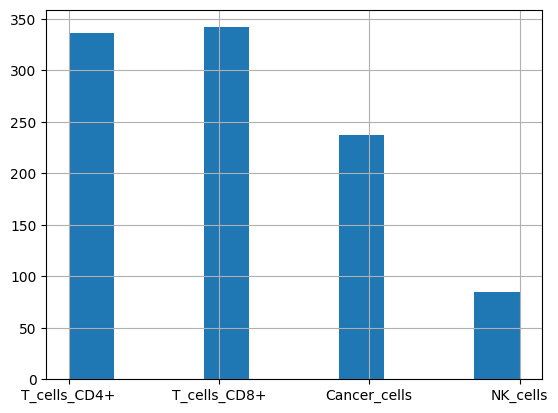

In [5]:
lab_df.label.hist()

In [6]:
print(X_train.shape)
print(type(X_train))

(1000, 13551)
<class 'scipy.sparse._csr.csr_matrix'>


We see that we have a fairly high dimensional problem with 1000 data points (unique cells) described by 14059 variables (genes). Since we measure expression level, the data is quite sparse, with many unexpressed genes for each cell. Thus, `get_*_data()` functions returns $X$ as a `scipy` [sparse matrix stored in row format](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html). This is useful 

    1. To save memory space
    2. Some algorithm may work with scipy's sparse CSR matrices.

Of course many existing algorithm, *e.g.* in scikit-learn, may throw error when given such an object, requiring a `np.array` type. Thankfully the `.toarray()` method straightforwadly converts to NumPy.

In [7]:
X_train.toarray().shape

(1000, 13551)

### A first look at the data

<div class="alert alert-block alert-warning">
<b>Warning:</b> This section purposedly presents a naive example of data manipulation. It is expected of you to dive deeper into the data analysis and do proper pre-processing. 

</div> 


A particularity of RNA-seq data is that total counts may vary widely between cells and/or genes.


In [8]:
X_train_df = pd.DataFrame(X_train.toarray())
X_train_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,13541,13542,13543,13544,13545,13546,13547,13548,13549,13550
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000
mean,0.258000,0.068000,0.028000,0.063000,0.056000,0.051000,0.007000,0.055000,0.084000,0.280000,...,0.016000,0.03000,0.093000,0.010000,0.02000,0.018000,0.04400,0.408000,0.077000,0.066000
std,2.355203,0.606419,0.221958,0.274055,0.284508,0.592241,0.094657,0.260851,0.359267,0.616425,...,0.133273,0.17644,0.602257,0.099549,0.14007,0.133018,0.22829,0.973902,0.327381,0.267798
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000
max,64.000000,11.000000,4.000000,2.000000,4.000000,13.000000,2.000000,3.000000,4.000000,4.000000,...,2.000000,2.00000,10.000000,1.000000,1.00000,1.000000,3.00000,9.000000,3.000000,2.000000


In [9]:
total_genes_counts = X_train.toarray().sum(axis=0)
total_cell_counts = X_train.toarray().sum(axis=1)

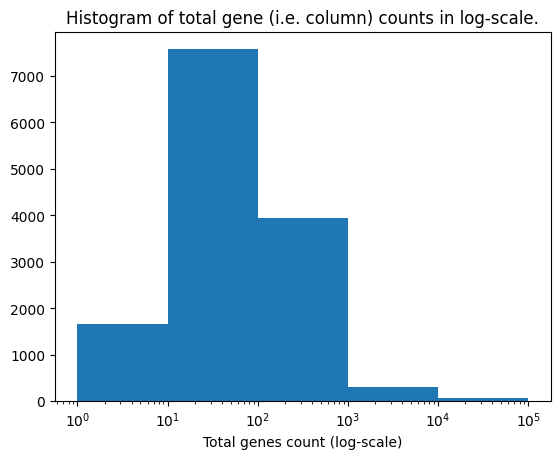

In [10]:
# plt.hist(np.log10(total_genes_counts), bins = np.arange(6))
plt.hist(total_genes_counts, bins = 10**np.arange(6))
plt.xscale("log")
plt.title("Histogram of total gene (i.e. column) counts in log-scale.")
plt.xlabel('Total genes count (log-scale)')
plt.show()

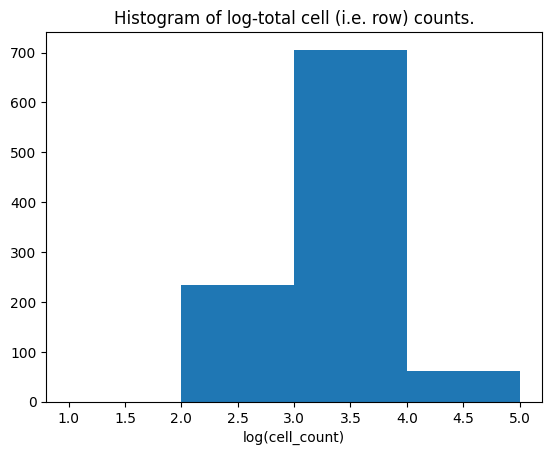

In [11]:
plt.hist(np.log10(total_cell_counts), bins = np.arange(1,6))
plt.title("Histogram of log-total cell (i.e. row) counts.")
plt.xlabel('log(cell_count)')
plt.show()

This suggests for some normalization of the counts. There are many normalization possible for RNA-seq data, and one of the goal of this challenge is to test for different pre-processing. For simplicity, here we choose to normalize each row (cell) by its total count.

In [23]:
def preprocess_X(X):
    X = X.toarray()
    return X / X.sum(axis=1)[:, np.newaxis]

X_train_norm = preprocess_X(X_train)
X_test_norm  = preprocess_X(X_test)
# sanity check
np.allclose(X_train_norm.sum(axis=1), np.ones(X_train_norm.shape[0]))

def preprocess_log(X):
    """
    Application du log(1 + x) pour réduire l'écart entre les valeurs
    """
    X_log = np.log1p(X)
    return X_log

X_train_log = preprocess_log(X_train_norm)
X_test_log  = preprocess_log(X_test_norm)
print("Train : min =", X_train_log.min(), ", max =", X_train_log.max())
print("Test : min =", X_test_log.min(), ", max =", X_test_log.max())

Train : min = 0.0 , max = 0.49066365
Test : min = 0.0 , max = 0.26696903


# The score function

This challenge scores your submissions and ranks participants with a balanced accuracy score, computed via the (unadjusted) sklearn's `balanced_accuracy_score` function.

Balanced accuracy is computed as the average of Recall scores for each class [see implementation for more details](https://github.com/scikit-learn/scikit-learn/blob/8c9c1f27b/sklearn/metrics/_classification.py#L2180). It is between 0 and 1, the higher, the better.

In [24]:
from sklearn.metrics import balanced_accuracy_score

In [25]:
# this custom class is used by the challenge and calls 
# balanced_accuracy_score(y_true, y_pred, adjusted=False)
# under the hood
from problem import BalancedAccuracy

# A first (naive) try at the challenge
We now show a first naive attempt at the challenge, and will proceed in two steps :

    1. First, we will construct a classifier step-by-step. 
    2. Then, we will show how to implement this classifier as a proper RAMP submision.
## Step-by-step construction of a classifier

Given the high-dimensional nature of the problem we will construct a classifier: standardize data, do a PCA retaining only the 50 first components, and finally fit a random forest classifier on the 50 first components.

This can be easily implemented as a scikit-learn `Pipeline`.

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingClassifier


pipe = Pipeline(
    [
        ("Scaler", StandardScaler(with_mean=True, with_std=True)),
        ("PCA with 50 components", PCA(n_components=50)),
        (
            "XBBoost Classifier",
           HistGradientBoostingClassifier(
                max_depth=3, max_features=1.0
            ),
        ),
    ]
)

pipe

Pipeline(steps=[('Scaler', StandardScaler()),
                ('PCA with 50 components', PCA(n_components=50)),
                ('XBBoost Classifier',
                 HistGradientBoostingClassifier(max_depth=3))])

In [38]:
# fit on train
pipe.fit(X_train_log, y_train)
y_tr_pred = pipe.predict(X_train_log)

# predict on test
X_test_log = preprocess_X(X_test)
y_te_pred = pipe.predict(X_test_log)


Train balanced accuracy : 1.000
Test balanced accuracy : 0.678


Text(0.5, 1.0, 'Confusion matrix on test set')

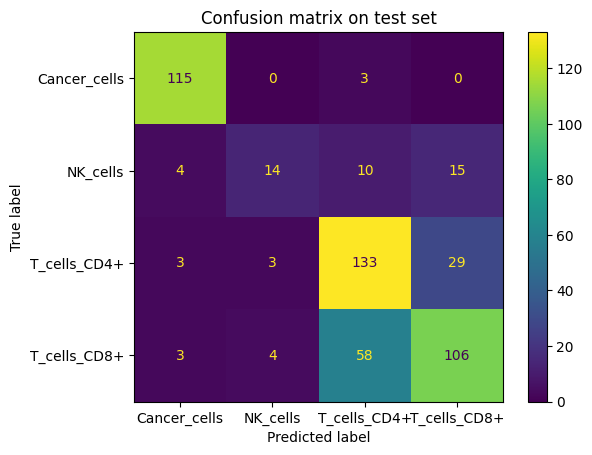

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred):.3f}")
cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_, )
disp.plot()
plt.title("Confusion matrix on test set")

This naive classifier does a better job than a dummy random classifier which would yield an average balanced accuracy of 1/4. 
However, it never predicts the "NK_cell" type and seems to confuse between the two different "T-cell" types. There seems to be room for improvement. Good news, it is your job ! :)

Next, let's see how to implement this exact same classifier as a receivable RAMP submission

In [32]:
print('Train balanced accuracy:', balanced_accuracy_score(y_train, y_tr_pred))
print('Test balanced accuracy:', balanced_accuracy_score(y_test, y_te_pred))

Train balanced accuracy: 0.9992690058479532
Test balanced accuracy: 0.6764126413623074


In [33]:
!ramp-test --submission xgboost_classifier

Testing Single-cell RNA-seq cell types classification
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/xgboost_classifier ...
CV fold 0
	score  bal_acc      time
	train     0.99  5.515744
	valid     0.68  0.173180
	test      0.63  0.127379
CV fold 1
	score  bal_acc      time
	train     0.98  4.364817
	valid     0.70  0.144909
	test      0.66  0.124901
CV fold 2
	score  bal_acc      time
	train     0.98  4.955400
	valid     0.62  0.143152
	test      0.66  0.124506
CV fold 3
	score  bal_acc      time
	train     0.97  4.218030
	valid     0.63  0.147385
	test      0.63  0.122834
CV fold 4
	score  bal_acc      time
	train     0.99  5.639287
	valid     0.66  0.144222
	test      0.66  0.118451
----------------------------
Mean CV scores
----------------------------
	score       bal_acc        time
	train  0.98 ± 0.006  4.9 ± 0.58
	valid   0.65 ± 0.03  0.2 ± 0.01
	test   0.65 ± 0.013   0.1 ± 0.0
----------------------------
Bagged scores
-----------------------

New parameters inside HistGradientBoosting Classifier

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingClassifier


pipe = Pipeline(
    [
        ("Scaler", StandardScaler(with_mean=True, with_std=True)),
        ("PCA with 50 components", PCA(n_components=50)),
        (
            "XBBoost Classifier",
           HistGradientBoostingClassifier(
                max_depth=2, max_features=0.5
            ),
        ),
    ]
)

pipe

Pipeline(steps=[('Scaler', StandardScaler()),
                ('PCA with 50 components', PCA(n_components=50)),
                ('XBBoost Classifier',
                 HistGradientBoostingClassifier(max_depth=2,
                                                max_features=0.5))])

In [57]:
# fit on train
pipe.fit(X_train_log, y_train)
y_tr_pred = pipe.predict(X_train_log)

# predict on test
X_test_log = preprocess_X(X_test)
y_te_pred = pipe.predict(X_test_log)

Train balanced accuracy : 0.975
Test balanced accuracy : 0.691


Text(0.5, 1.0, 'Confusion matrix on test set')

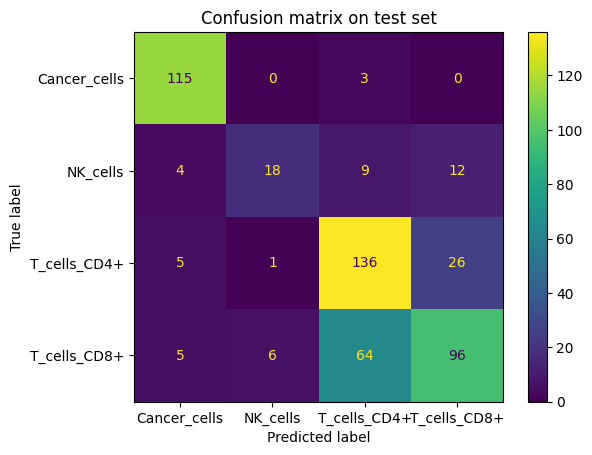

In [58]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred):.3f}")
cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_, )
disp.plot()
plt.title("Confusion matrix on test set")

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingClassifier


pipe = Pipeline(
    [
        ("Scaler", StandardScaler(with_mean=True, with_std=True)),
        ("PCA with 50 components", PCA(n_components=50)),
        (
            "XBBoost Classifier",
           HistGradientBoostingClassifier(
                max_depth=3, max_features=0.2
            ),
        ),
    ]
)

pipe

Pipeline(steps=[('Scaler', StandardScaler()),
                ('PCA with 50 components', PCA(n_components=50)),
                ('XBBoost Classifier',
                 HistGradientBoostingClassifier(max_depth=3,
                                                max_features=0.2))])

In [60]:
# fit on train
pipe.fit(X_train_log, y_train)
y_tr_pred = pipe.predict(X_train_log)

# predict on test
X_test_log = preprocess_X(X_test)
y_te_pred = pipe.predict(X_test_log)

Train balanced accuracy : 0.999
Test balanced accuracy : 0.687


Text(0.5, 1.0, 'Confusion matrix on test set')

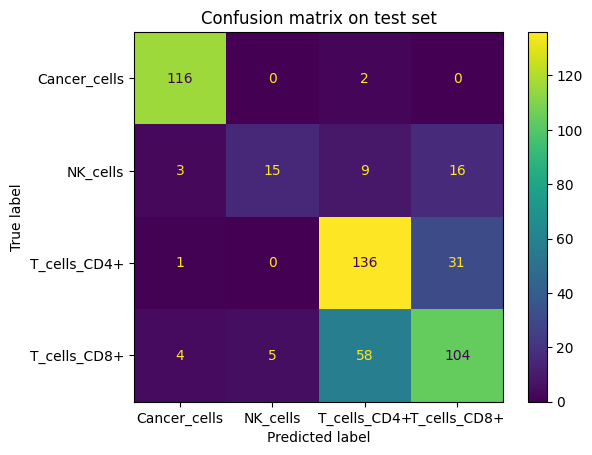

In [61]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred):.3f}")
cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_, )
disp.plot()
plt.title("Confusion matrix on test set")

In [74]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingClassifier


pipe = Pipeline(
    [
        ("PCA with 50 components", PCA(n_components=50)),
        (
            "XBBoost Classifier",
           HistGradientBoostingClassifier(
                max_depth=3, max_features=1.0
            ),
        ),
    ]
)

pipe

Pipeline(steps=[('PCA with 50 components', PCA(n_components=50)),
                ('XBBoost Classifier',
                 HistGradientBoostingClassifier(max_depth=3))])

In [75]:
# fit on train
pipe.fit(X_train_log, y_train)
y_tr_pred = pipe.predict(X_train_log)

# predict on test
X_test_log = preprocess_X(X_test)
y_te_pred = pipe.predict(X_test_log)

Train balanced accuracy : 1.000
Test balanced accuracy : 0.741


Text(0.5, 1.0, 'Confusion matrix on test set')

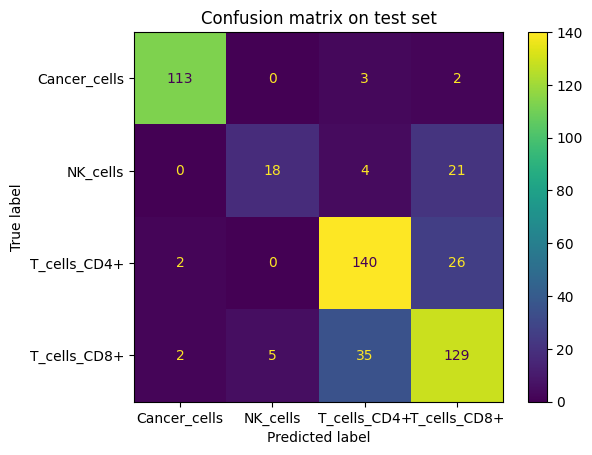

In [76]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred):.3f}")
cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_, )
disp.plot()
plt.title("Confusion matrix on test set")

In [102]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingClassifier


pipe = Pipeline(
    [
        ("PCA with 50 components", PCA(n_components=50)),
        (
            "XBBoost Classifier",
           HistGradientBoostingClassifier(
                max_depth=10, max_features=0.1
            ),
        ),
    ]
)

pipe

Pipeline(steps=[('PCA with 50 components', PCA(n_components=50)),
                ('XBBoost Classifier',
                 HistGradientBoostingClassifier(max_depth=10,
                                                max_features=0.1))])

In [103]:
# fit on train
pipe.fit(X_train_log, y_train)
y_tr_pred = pipe.predict(X_train_log)

# predict on test
X_test_log = preprocess_X(X_test)
y_te_pred = pipe.predict(X_test_log)

Train balanced accuracy : 1.000
Test balanced accuracy : 0.743


Text(0.5, 1.0, 'Confusion matrix on test set')

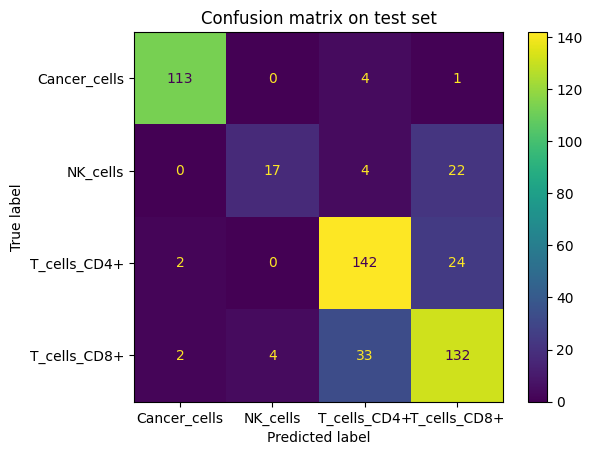

In [104]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred):.3f}")
cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_, )
disp.plot()
plt.title("Confusion matrix on test set")